In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  0.1.68


<h2>Retrieve Model</h2>

In [2]:
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model=Model(ws, 'sklearn_mnist')
model.download(target_dir = '.')
import os 
# verify the downloaded model file
os.stat('./sklearn_mnist_model.pkl')

Found the config file in: C:\Development\GitHub\marcelfranke\azureml\GetStarted\config.json


os.stat_result(st_mode=33206, st_ino=2251799814031806, st_dev=4041685168, st_nlink=1, st_uid=0, st_gid=0, st_size=63670, st_atime=1541426838, st_mtime=1541426838, st_ctime=1541426838)

<h2>Test model locally</h2>

<h3>Load test data</h3>

In [4]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

<h3>Predict test data</h3>

In [5]:
import pickle
from sklearn.externals import joblib

clf = joblib.load('./sklearn_mnist_model.pkl')
y_hat = clf.predict(X_test)

<h3>Examine the confusion matrix</h3>

In [7]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    1    2    1    5    6    3    1    1]
 [   0 1112    3    1    0    1    5    1   12    0]
 [   9    8  920   20   10    4   10   11   37    3]
 [   4    0   17  921    2   21    4   12   20    9]
 [   1    2    5    3  915    0   10    2    6   38]
 [  10    2    0   41   10  770   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    7   22    5    8    1    1  950    5   27]
 [  10   15    5   21   15   27    7   11  851   12]
 [   7    8    2   13   32   13    0   24   12  898]]
Overall accuracy: 0.9204


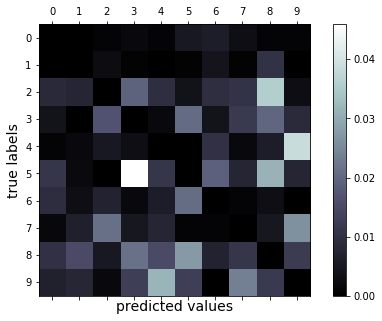

In [8]:
# normalize the diagnal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

<h2>Deploy as web service</h2>

<h3>Create scoring script</h3>

In [10]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    return json.dumps(y_hat.tolist())

Writing score.py


<h3>Create environment file</h3>

In [12]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [13]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.

  - azureml-defaults
- scikit-learn



<h3>Create configuration file</h3>

In [14]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

<h3>Deploy in ACI</h3>

In [16]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='sklearn-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image sklearn-mnist-svc:1, operation "Succeeded"
Creating service
Running..........................................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 8min 5s


In [17]:
print(service.scoring_uri)

http://40.115.62.194:80/score


<h2>Test deployed service</h2>

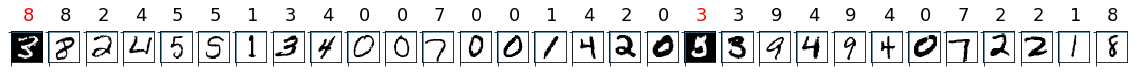

In [18]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding = 'utf8')

# predict using the deployed model
result = json.loads(service.run(input_data=test_samples))

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys

    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)

    i = i + 1
plt.show()

In [19]:
import requests
import json

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://40.115.62.194:80/score
label: 1
prediction: "[1]"


<h2>Clean up resources</h2>

In [20]:
service.delete()